In [ ]:
import numpy as np
import numpy.random as nr

def data_generation(count, deviation, dt):#dt - время (изменение времени с предыдущего состояния до текущего)
   # Шум с нормальным распределением. мат. ожидание = 0, среднеквадратичное отклонение = deviation, count - форма возвращаемого массива
   noise = nr.normal(loc = 0.0, scale = deviation, size = count)#loc - мат.ожидание
   path = np.zeros((3, count))# Fx
   x = 0
   v = 1.0
   a = 0.0
   for i in range(1, count):
       x += v * dt + (a * dt ** 2) / 2.0 #x=x0+vt+at^2/2
       v += a * dt
       a = a
       path[0][i] = x
       path[1][i] = v
       path[2][i] = a

   data = path[0] + noise

   return path, data # Истинное значение и данные "датчика" с шумом

In [ ]:
#!pip install filterpy


In [ ]:
import filterpy.kalman
import filterpy.common
import matplotlib.pyplot as plt
import numpy as np
import numpy.random

dt = 0.01                       # дельта времени
disp = 0.5          # среднеквадратичное отклонение
dataNoise = 1e-4             # погрешность ("шум") модели

# Моделирование данных датчиков
coord, measure = data_generation(1000, disp, dt)#пусть будет 1000 измерений

# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=3,  dim_z=1)   # Размер вектора стостояния x и вектора измерений z

# F - матрица процесса - размер dim_x на dim_x - 3х3
filter.F = np.array([ [1,   dt,     (dt**2)/2],
                     [0,   1.0,    dt],
                     [0,   0,      1.0]])

# Матрица наблюдения H - dim_z на dim_x - 1x3
filter.H = np.array([[1.0, 0.0, 0.0]])

# Ковариационная матрица Q ошибки модели
filter.Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt, var=dataNoise)

# Ковариационная матрица R ошибки измерения - 1х1
filter.R = np.array([[disp*disp]])

# Начальное состояние. x0
filter.x = np.array([0.0, 0.0, 0.0])

# Ковариационная матрица P для начального состояния
filter.P = np.array([[20.0, 0.0,  0.0],
                    [0.0,  20.0, 0.0],
                    [0.0,  0.0,  20.0]])

filteredState = [] #вектор оценки состояния
stateCovarianceHistory = [] #вектор обновления ковариации
# Обработка данных
for i in range(0, len(measure)):
   z = [ measure[i] ]                      # Вектор измерений
   filter.predict()                            # Этап предсказания
   filter.update(z)                            # Этап коррекции

   filteredState.append(filter.x)
   stateCovarianceHistory.append(filter.P)

filteredState = np.array(filteredState)
stateCovarianceHistory = np.array(stateCovarianceHistory)

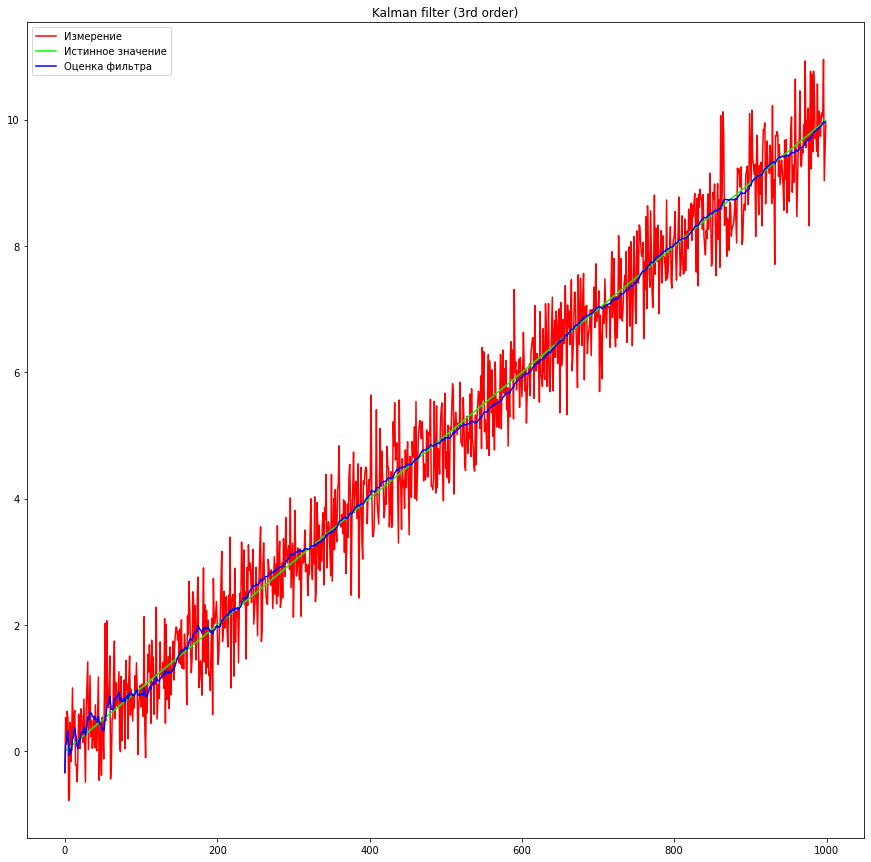

In [ ]:
# Визуализация
plt.figure(figsize=(15, 15))
plt.title("Kalman filter (3rd order)")
plt.plot(measure, label="Измерение", color="#FF0000")
plt.plot(coord[0], label="Истинное значение", color="#00FF00")
plt.plot(filteredState[:, 0], label="Оценка фильтра", color="#0000FF")
plt.legend()

In [ ]:
#Фильтр Калмана без запаха
"""dt = 0.01                       # дельта времени
disp = 0.5          # среднеквадратичное отклонение
dataNoise = 1e-4             # погрешность ("шум") модели"""

# Функция наблюдения - аналог матрицы наблюдения
# Преобразует вектор состояния x в вектор измерений z
def xToZ(x):
   return np.array([x[0]])

# Функция процесса - аналог матрицы процесса
def processFunc(x, dt):
   newState = np.zeros(3)
   newState[0] = x[0] + dt * x[1] + ( (dt**2)/2 ) * x[2]
   newState[1] = x[1] + dt * x[2]
   newState[2] = x[2]

   return newState


# Для unscented kalman filter необходимо выбрать алгоритм выбора сигма-точек
sigma_points = filterpy.kalman.JulierSigmaPoints(3, kappa=0)

# Создаём объект UnscentedKalmanFilter
filter_u = filterpy.kalman.UnscentedKalmanFilter(dim_x = 3,
                                              dim_z = 1,
                                              dt = dt,
                                              hx = xToZ,
                                              fx = processFunc,
                                              points = sigma_points)



# Ковариационная матрица ошибки модели
filter_u.Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt, var=dataNoise)

# Ковариационная матрица ошибки измерения - 1х1
filter_u.R = np.array([[disp*disp]])

# Начальное состояние.
filter_u.x = np.array([0.0, 0.0, 0.0])

# Ковариационная матрица для начального состояния
filter_u.P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])

filteredState_u = []
stateCovarianceHistory_u = []

for i in range(0, len(measure)):
   z = [ measure[i] ]
   filter_u.predict()
   filter_u.update(z)

   filteredState_u.append(filter_u.x)
   stateCovarianceHistory_u.append(filter_u.P)

filteredState_u = np.array(filteredState_u)
stateCovarianceHistory_u = np.array(stateCovarianceHistory_u)

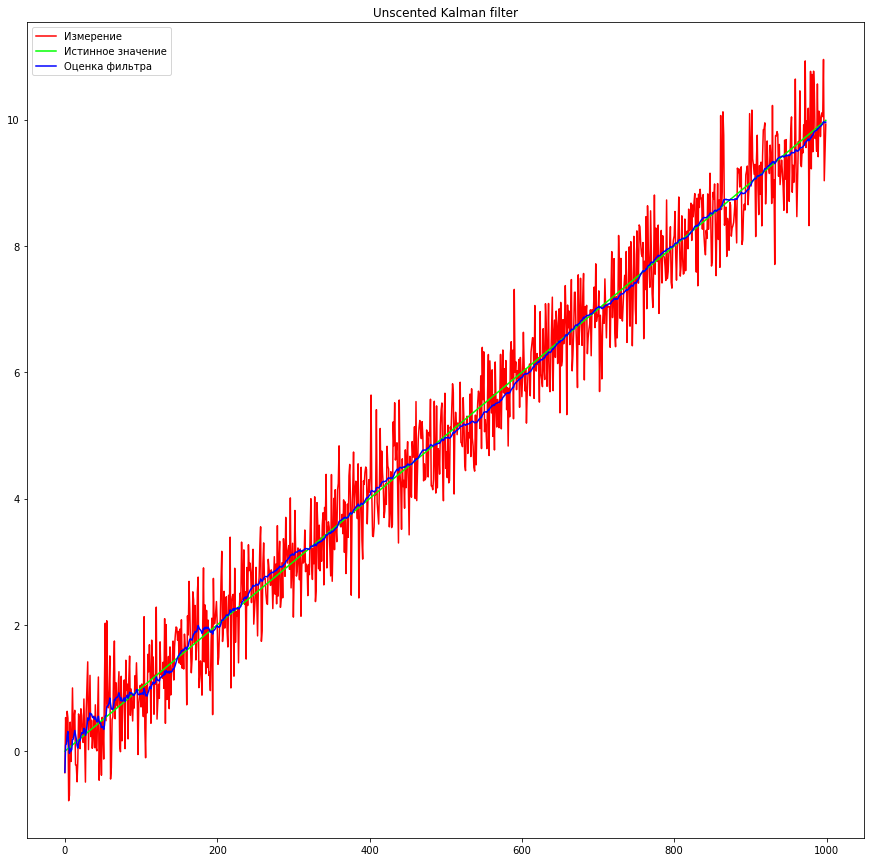

In [ ]:
# Визуализация UKF
plt.figure(figsize=(15,15))
plt.title("Unscented Kalman filter")
plt.plot(measure, label="Измерение", color="#FF0000")
plt.plot(coord[0], label="Истинное значение", color="#00FF00")
plt.plot(filteredState_u[:, 0], label="Оценка фильтра", color="#0000FF")
plt.legend()

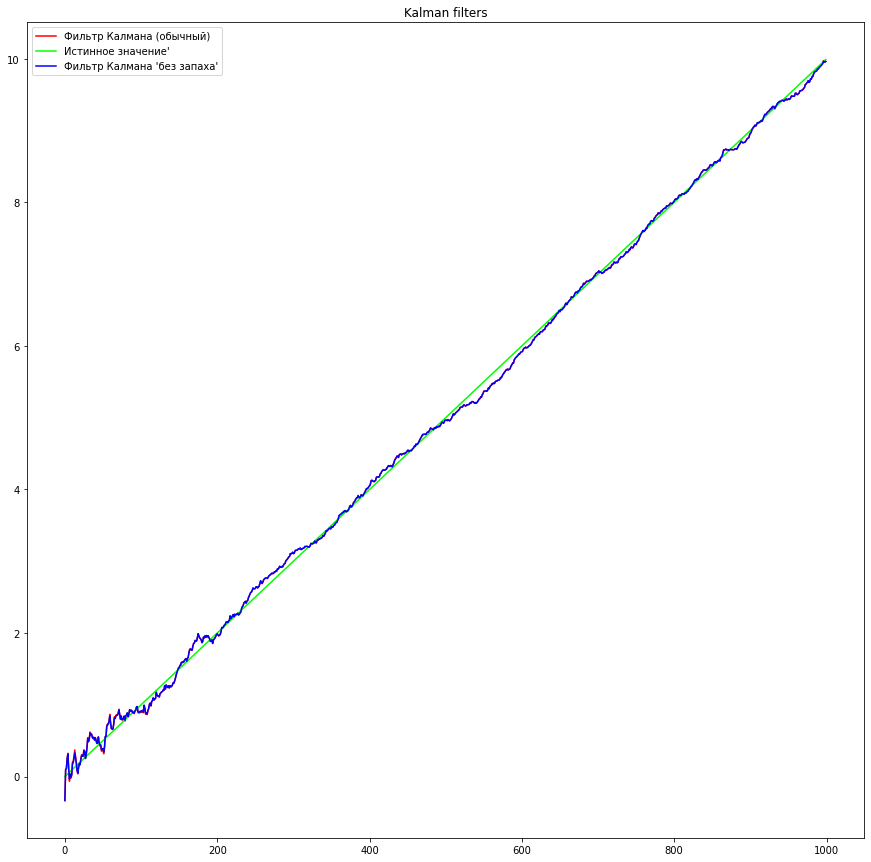

In [ ]:
# Сравнение фильтров
plt.figure(figsize=(15, 15))
plt.title("Kalman filters")
plt.plot(filteredState[:, 0], label="Фильтр Калмана (обычный)", color="#FF0000")
plt.plot(coord[0], label="Истинное значение'", color="#00FF00")
plt.plot(filteredState_u[:, 0], label="Фильтр Калмана 'без запаха'", color="#0000FF")
plt.legend()

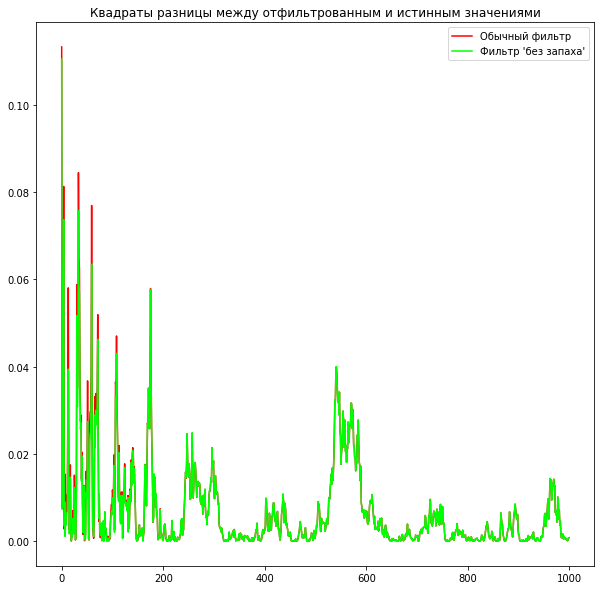

In [ ]:
plt.figure(figsize=(10, 10))
plt.title("Квадраты разницы между отфильтрованным и истинным значениями")
plt.plot(np.power(filteredState[:, 0]-coord[0], 2), label = "Обычный фильтр", color="#FF0000")
plt.plot(np.power(filteredState_u[:, 0]-coord[0], 2),  label = "Фильтр 'без запаха'", color="#00FF00")
plt.legend()

In [ ]:
#Mean Square Error
def MSE(y_true, y_pred):
    return round((np.power(y_true - y_pred, 2).mean())*100, 2)

In [ ]:
#ошибка фильтра, %
MSE(filteredState[:, 0], coord[0])

0.68

In [ ]:
#ошибка UKF, %
MSE(filteredState_u[:, 0], coord[0])

0.66